# Chapter 7 - Exercise 2
### Author: *John Benedick Estrada*
---
**Exercise:** In 1990 Bak, Chen and Tang proposed a cellular automaton that is
an abstract model of a forest fire.  Each cell is in one of three
states: empty, occupied by a tree, or on fire.

The rules of the CA are:

* An empty cell becomes occupied with probability $p$.

* A cell with a tree burns if any of its neighbors
  is on fire.

* A cell with a tree spontaneously burns, with
  probability $f$, even if none of its neighbors is on fire.

* A cell with a burning tree becomes an empty cell in the next
  time step.

Write a
program that implements it.  You might want to inherit from `Cell2D`.
Typical values for the parameters are
$p=0.01$ and $f=0.001$, but you might want to experiment with other
values.

Starting from a random initial condition, run the CA until it reaches
a steady state where the number of trees no longer increases or
decreases consistently.  

In steady state, is the geometry of the forest fractal?
What is its fractal dimension?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Cell2D import Cell2D
from scipy.signal import correlate2d
from matplotlib.colors import LinearSegmentedColormap
from utils import underride

### Forest Fire CA implementation

In [2]:
class ForestFire(Cell2D):
    EMPTY = 0
    LIVE_TREE = 1
    BURNING_TREE = 5

    # Color map
    cmap = LinearSegmentedColormap.from_list(
                "forest_fire_cmap",
                [(EMPTY/BURNING_TREE, "w"), 
                 (LIVE_TREE/BURNING_TREE, "g"),
                 (BURNING_TREE/BURNING_TREE, "r")]
            )

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    
    def __init__(self, n, m=None, p=0.01, f=0.001):
        super().__init__(n, m)
        self.p = p
        self.f= f
        
        self.n, self.m = self.array.shape

    def step(self):
        neighbor_check = correlate2d(self.array, self.kernel, mode="same", boundary="wrap")
        rand_mask = np.random.random(self.array.shape)

        # RULE 1: An empty cell becomes occupied with probability `p`.
        new_trees = (self.array == self.EMPTY) & (rand_mask < self.p)
        # RULE 2: A cell with a tree burns if any of its neighbors is on fire.
        burning = (self.array == self.LIVE_TREE) & (neighbor_check >= 5)
        # RULE 3: A cell with a tree spontaneously burns, with probability `f`, even if none of its neighbors is on fire.
        spontaneous = (self.array == self.LIVE_TREE) & (rand_mask < self.f)
        # RULE 4: A cell with a burning tree becomes an empty cell in the next time step. 
        empty_cells = (self.array == self.BURNING_TREE)

        self.array[new_trees] = self.LIVE_TREE
        self.array[burning] = self.BURNING_TREE
        self.array[spontaneous] = self.BURNING_TREE
        self.array[empty_cells] = self.EMPTY
    
    def draw(self, **options):
        options = underride(options,
                            cmap=self.cmap,
                            alpha=0.7,
                            interpolation='none', 
                            origin='upper',
                            extent=[0, self.m, 0, self.n])
        plt.axis([0, self.m, 0, self.n])
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(self.array, **options)


def make_rand_forest_fire(n, m=None, p=0.01, f=0.001):
    ff = ForestFire(n, m, p, f)

    empty, live, burning = 0, 1, 2
    rand_state = np.random.randint(0, 3, size=ff.array.shape)
    rand_state[rand_state == burning] = ff.BURNING_TREE
    ff.array = rand_state
    return ff

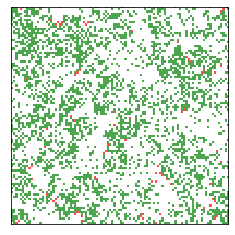

In [3]:
test_ff = make_rand_forest_fire(100, 100)
test_ff.animate(100)